<img src="http://bibliotecadigital.fgv.br/dspace/bitstream/id/45381/?sequence=-1" align="right" height="104" width="240" >
TCC
========
#### Helder Rezende
------

In [252]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
import arch
import scipy
from scipy.stats import t
from scipy.optimize import fmin
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

%matplotlib inline

### Referências bibliográficas 

http://www.crest.fr/ckfinder/userfiles/files/pageperso/fermania/chapter-book-copula-density-estimation.pdf

https://risk-engineering.org/VaR/

http://www.analyticsresearch.net/Documents/2013AFEsession5.Practicals.pdf

financephd.typepad.com/files/copulas.pdf

http://www.impa.br/opencms/pt/ensino/downloads/mestrado_profissional_projeto_fim_curso/projetos_fim_cursos_2013/Cristiane_Azevedo.pdf


http://epub.lib.aalto.fi/fi/ethesis/pdf/12049/hse_ethesis_12049.pdf

financephd.typepad.com/files/copulas.pdf

### Introdução

O objetivo do trabalho primeiramente é analisar os modelos de VAR e volatilidade na crise brasileira.

In [254]:
ativos = ['FIBR3', 'PETR4','ITUB4','BBDC4']
N = len(ativos)
cotacoesFibr = web.DataReader('FIBR3.SA', data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close']
cotacoesPetr = web.DataReader('PETR4.SA', data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close']
cotacoesItub = web.DataReader('ITUB4.SA', data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close']
cotacoesBbdc = web.DataReader('BBDC4.SA', data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close']

In [255]:
cotacoes_list = [cotacoesFibr,cotacoesPetr,cotacoesItub,cotacoesBbdc]
cotacoes = pd.DataFrame(index = ativos, data = cotacoes_list).transpose().dropna()
cotacoes_carteira = cotacoes.sum(axis=1)/4

In [256]:
def log_retorno(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

In [257]:
retornos = [log_retorno(cotacoes_list[x]) for x in range(len(cotacoes_list))]
retornos = pd.DataFrame(index = ativos, data = retornos)
retornos = retornos.transpose().dropna()

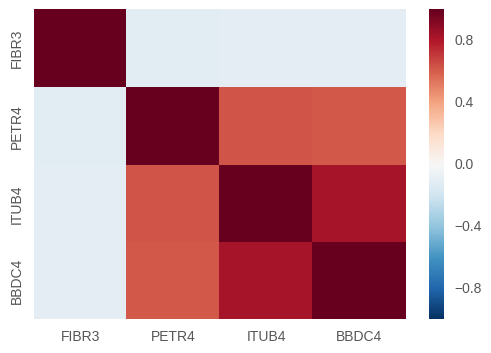

In [258]:
corr = retornos.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [259]:
corr

,FIBR3,PETR4,ITUB4,BBDC4
FIBR3,1.000000,-0.110310,-0.107282,-0.107453
PETR4,-0.110310,1.000000,0.630050,0.617212
ITUB4,-0.107282,0.630050,1.000000,0.829883
BBDC4,-0.107453,0.617212,0.829883,1.000000


In [260]:
retornos_carteira = retornos.sum(axis=1)/4

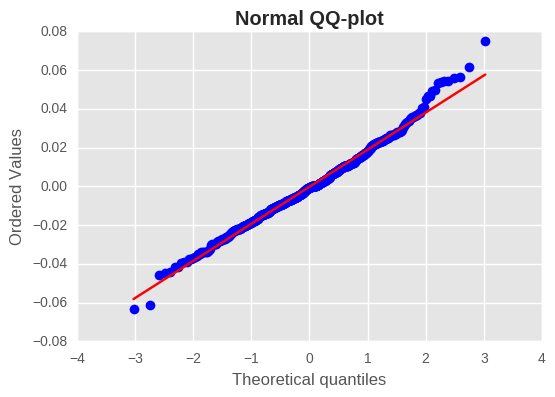

In [261]:
Q = retornos_carteira.as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot", weight="bold");

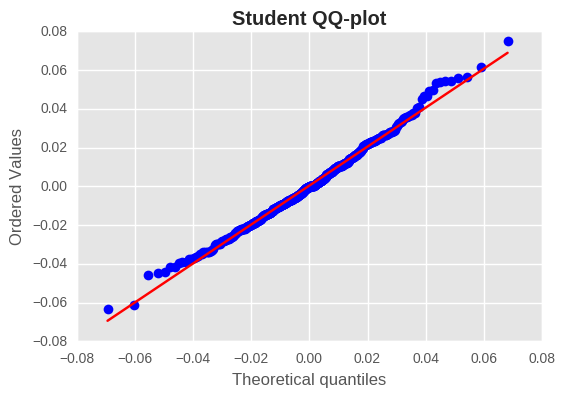

In [262]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot", weight="bold");

### BackTesting - Configuração

Cenários de Backtestings:

In [263]:
pd.DataFrame({"Data Inicial" : ['3/21/2015',' 3/25/2014','4/5/2012'],"Data Final" : '4/1/2016'} , index = [255,510,1000])

,Data Final,Data Inicial
255,4/1/2016,3/21/2015
510,4/1/2016,3/25/2014
1000,4/1/2016,4/5/2012


#### Kupiec Tests 

Tabela de Não-Rejeição de acordo o numero de falhas N.

In [264]:
Kupiec = pd.DataFrame(index = [0.01,0.025,0.05,0.075,0.01])

In [265]:
Kupiec["VaR"] = ["99%"," 97.5","95%", "92.5%","90%"]
Kupiec["T = 255 dias"] = ["N<7", "2<N<12", "6<N<21", "11<N<28", "16<N<36"]
Kupiec["T = 510 dias"] = ["1<N<11", "6<N<21", "16<N<36", "27<N<51", "38<N<65"]
Kupiec["T = 1000 dias"] = ["4<N<17", "15<N<36", "37<N<65", "59<N<92", "81<N<120"]

In [266]:
Kupiec

,VaR,T = 255 dias,T = 510 dias,T = 1000 dias
0.010,99%,N<7,1<N<11,4<N<17
0.025,97.5,2<N<12,6<N<21,15<N<36
0.050,95%,6<N<21,16<N<36,37<N<65
0.075,92.5%,11<N<28,27<N<51,59<N<92
0.010,90%,16<N<36,38<N<65,81<N<120


### 1 - VaR histórico

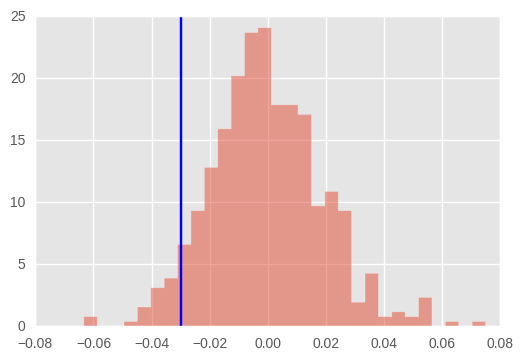

In [267]:
confianca = 0.95

retornos_carteira.hist(bins=30,normed=True,histtype='stepfilled',alpha=0.5)

plt.axvline(x=retornos_carteira.quantile([1-confianca,confianca])[1-confianca], color='b')

In [268]:
def var_historico(retornos, confianca):
    
    return retornos.quantile(1-confianca)
        

In [269]:
var_99_historico = retornos_carteira.quantile(1-0.99)
var_95_historico = retornos_carteira.quantile(1-0.95)
var_90_historico = retornos_carteira.quantile(1-0.90)

cvar_99_historico=[]
cvar_95_historico=[]
cvar_90_historico=[]

for x in retornos_carteira:
    if x <var_99_historico:
        cvar_99_historico.append(x)
    if x <var_95_historico:
        cvar_95_historico.append(x)
    if x <var_90_historico:
        cvar_90_historico.append(x)

    
var_historico = pd.DataFrame(index =[0.90,0.95,0.99])
var_historico['VaR(%)'] = [var_90_historico*100,var_95_historico*100,var_99_historico*100]
var_historico['CVaR(%)'] = [np.mean(cvar_90_historico)*100,np.mean(cvar_95_historico)*100,np.mean(cvar_99_historico)*100]
var_historico

,VaR(%),CVaR(%)
0.90,-2.259802,-3.232718
0.95,-2.977925,-3.831478
0.99,-4.157412,-5.011531


### 1.2 BackTesting

In [270]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
inicio = len(retornos_carteira) - 255
final = len(retornos_carteira)
for x in range(inicio,final):
   
    lista_var95.append(retornos_carteira[x-255:x].quantile(0.05))
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
    lista_var90.append(retornos_carteira[x-255:x].quantile(0.1))
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
    lista_var99.append(retornos_carteira[x-255:x].quantile(0.01))
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1
    
retornos_carteira_plot = retornos_carteira[inicio:final]

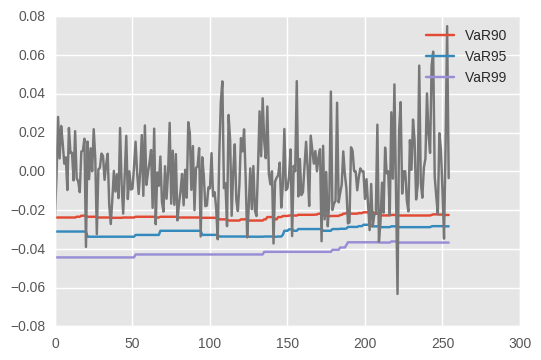

In [271]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [272]:
backtesting_historio = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 255 dias"])
backtesting_historio["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_historio

,Excecoes para 255 dias,T = 255 dias
VaR 90,24,16<N<36
VaR 95,12,6<N<21
VaR 99,1,N<7


### 2 - VaR paramétrico

#### 2.1 - Calculando a volatilidade histórica

In [273]:
volatilidade_valores = []

volatilidade_valores_com_na = pd.rolling_std(retornos_carteira,60)
volatilidade_valores = volatilidade_valores_com_na.dropna()


volatilidade = pd.DataFrame(volatilidade_valores,columns = ["Index IBOVESPA"])

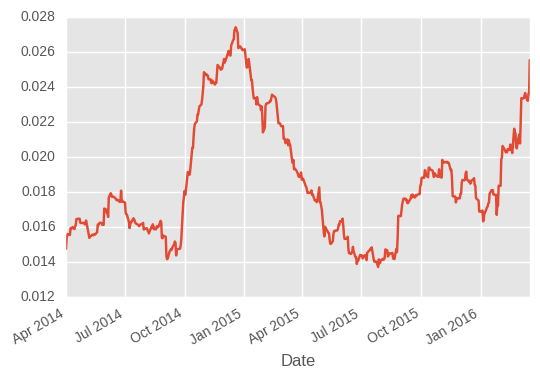

In [274]:
volatilidade_valores.plot()

#### 2.1.1 - VaR

In [275]:
var_parametrico = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99], columns = ["Alpha"])

In [276]:
var_parametrico['VAR(%)'] = (volatilidade_valores.iloc[-1]) * var_parametrico*-100


In [277]:
var_parametrico

,Alpha,VAR(%)
0.90,1.28,-3.266065
0.95,1.65,-4.210162
0.99,2.23,-5.690098


#### 2.1.1.1 - BackTesting

In [278]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_com_na.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_com_na.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_com_na.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1
    

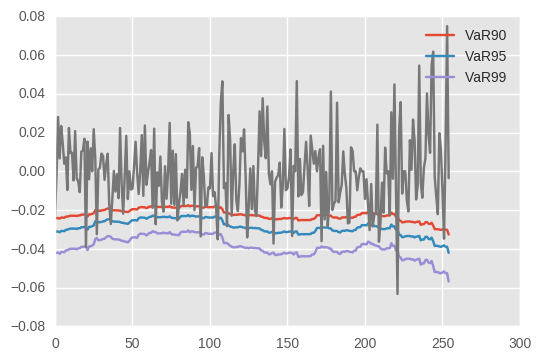

In [279]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [280]:
backtesting_parametrico = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_parametrico["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico

,Excecoes para 252 dias,T = 255 dias
VaR 90,31,16<N<36
VaR 95,16,6<N<21
VaR 99,3,N<7


#### 2.2 - Calculando a volatidade usando EWMA

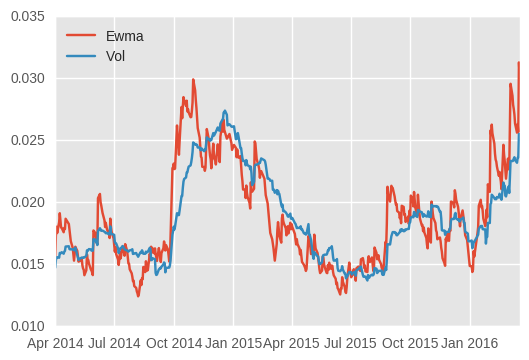

In [281]:
variance = retornos_carteira**2
ewma_variance = pd.ewma(variance, span = 30)
volatilidade_valores_ewma = pd.DataFrame([ewma_variance]).apply(sqrt)


plt.plot(volatilidade_valores_ewma[60:], label = 'Ewma')
plt.plot(volatilidade_valores, label = 'Vol')
plt.legend(loc = 2)

#### 2.2.1 - BackTesting

In [282]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_ewma.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_ewma.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_ewma.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

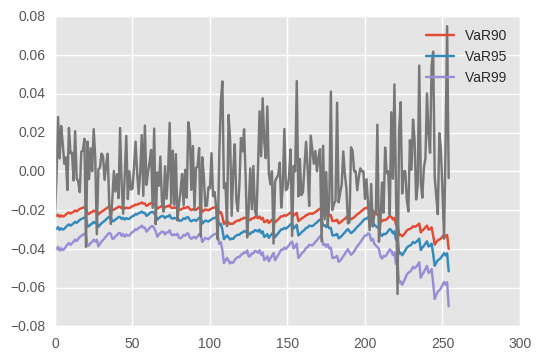

In [283]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [284]:
backtesting_parametrico_ewma = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])

backtesting_parametrico_ewma["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico_ewma

,Excecoes para 252 dias,T = 255 dias
VaR 90,29,16<N<36
VaR 95,14,6<N<21
VaR 99,2,N<7


#### 2.2.1 - VaR

In [285]:
var_parametrico_ewma = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])

In [286]:
var_parametrico_ewma['VAR(%)'] = (volatilidade_valores_ewma[-1]) * var_parametrico_ewma *100

In [287]:
var_parametrico_ewma

,Alpha,VAR(%)
0.90,1.28,3.874151
0.95,1.65,4.994023
0.99,2.23,6.749498


#### 2.3 - Calculando a volatidade usando GARCH(1,1)

In [288]:
am = arch_model(retornos_carteira)
res = am.fit(update_freq=5)
volatilidade_valores_garch = res.conditional_volatility

Iteration:      5,   Func. Count:     54,   Neg. LLF: -1431.5618949247946
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1431.56613152
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations: 7


/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


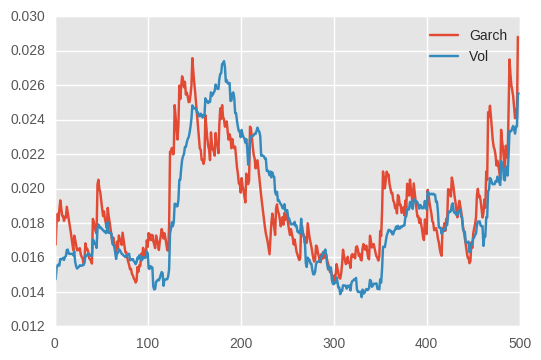

In [289]:
plt.plot(volatilidade_valores_garch.as_matrix()[60:], label='Garch')
plt.plot(volatilidade_valores.as_matrix(), label = 'Vol')
plt.legend()

#### 2.3.1 - VaR

In [290]:
var_parametrico_garch = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])
var_parametrico_garch['VAR(%)'] = (volatilidade_valores_garch[-1]) * var_parametrico_garch *100
var_parametrico_garch

,Alpha,VAR(%)
0.90,1.28,3.686883
0.95,1.65,4.752623
0.99,2.23,6.423241


#### 2.3.2 - BackTesting

In [291]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_garch.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_garch.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_garch.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

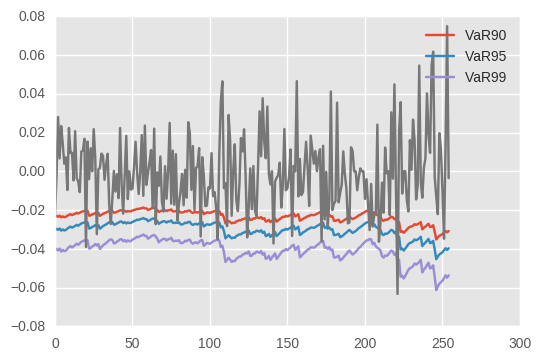

In [292]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [293]:
backtesting_parametrico_garch = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_parametrico_garch["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico_garch

,Excecoes para 252 dias,T = 255 dias
VaR 90,26,16<N<36
VaR 95,14,6<N<21
VaR 99,3,N<7


### 3 - VaR Monte Carlo

In [244]:
def random_walk(cotacoes):
    retornos = cotacoes.pct_change().dropna() 
    days = 2
    dt = 1/float(days)
    sigma = retornos.std()
    mu = retornos.mean()
    startprice = cotacoes[-1]
    
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return (price[-1]/startprice - 1)

#### 3.1 - VaR

In [246]:
def monte_carlo(cotacoes):
    runs = 100
    simulations = []
    for run in range(runs):
        simulations.append(random_walk(cotacoes_bovespa))
    simulations = pd.DataFrame([simulations]).transpose()
    return simulations

simulations = monte_carlo(retornos_carteira)

In [294]:
var_99_montecarlo = simulations.quantile(0.01)[0]
var_95_montecarlo = simulations.quantile(0.05)[0]
var_90_montecarlo = simulations.quantile(0.10)[0]

In [295]:
var_montecarlo = pd.DataFrame(index =[0.90,0.95,0.99])
var_montecarlo['VaR(%)'] = [var_90_montecarlo*100,var_95_montecarlo*100,var_99_montecarlo*100]

In [296]:
var_montecarlo

,VaR(%)
0.90,-1.038151
0.95,-1.459673
0.99,-2.783807


### 3.2 - BackTesting

In [298]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(monte_carlo(cotacoes_carteira.ix[x-255:x]).quantile(0.05)[0])
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(monte_carlo(cotacoes_carteira.ix[x-255:x]).quantile(0.10)[0])
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(monte_carlo(cotacoes_carteira.ix[x-255:x]).quantile(0.01)[0])
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

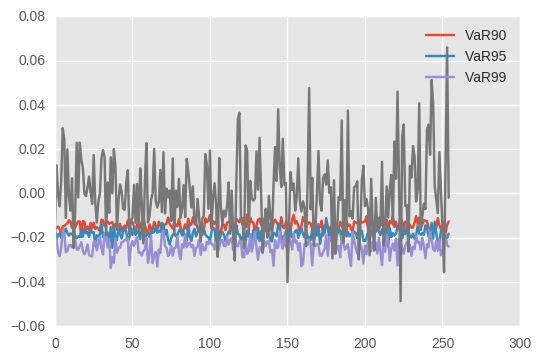

In [299]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_bovespa_plot.as_matrix())
plt.legend()

In [300]:
backtesting_montecarlo = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_montecarlo["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_montecarlo

,Excecoes para 252 dias,T = 255 dias
VaR 90,67,16<N<36
VaR 95,43,6<N<21
VaR 99,20,N<7


### Using Extreme Value Theory and Copulas to Evaluate Market Risk

<img src="image.JPG">



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


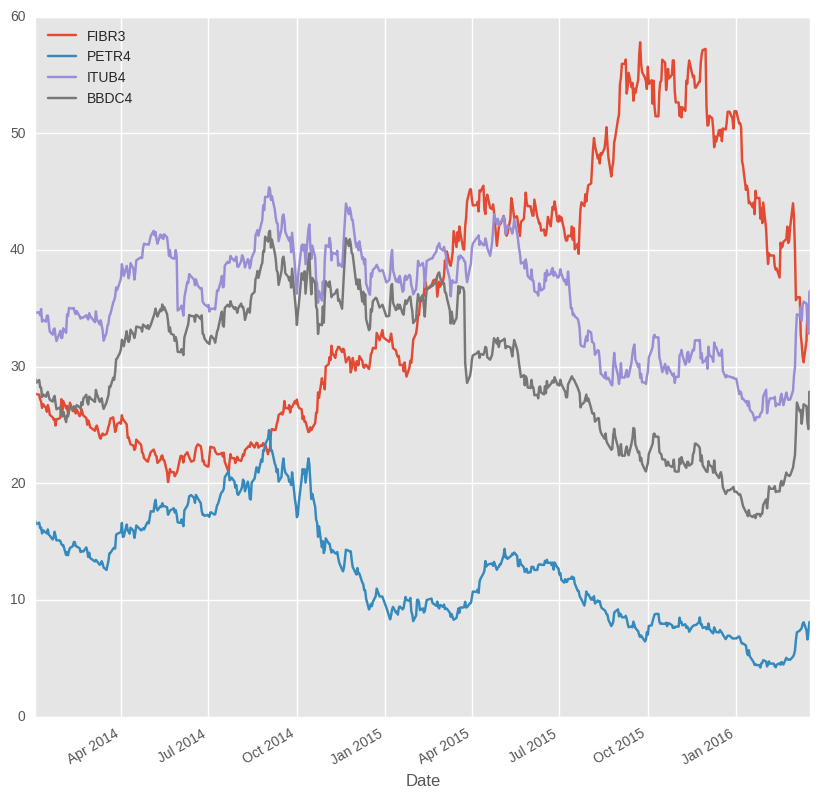

In [302]:
cotacoes.plot(figsize= (10,10))

In preparation for subsequent modeling, convert the closing level of each index to daily logarithmic returns (sometimes called geometric, or continuously compounded, returns).

Since the first step in the overall modeling approach involves a repeated application of GARCH filtration and Extreme Value Theory to characterize the distribution of each individual equity index return series, it is helpful to examine the details for a particular country. You can change the next line of code to any integer in the set {1,2,3,4,5,6} to examine the details for any index.

## Filter the Returns for Each Index

Fonte de estudo para essa parte: https://www.otexts.org/fpp/8/3
https://pypi.python.org/pypi/arch/3.0#bootstrap

Modeling the tails of a distribution with a GPD requires the observations to be approximately independent and identically distributed (i.i.d.). However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

For example, the sample autocorrelation function (ACF) of the returns associated with the selected index reveal some mild serial correlation.

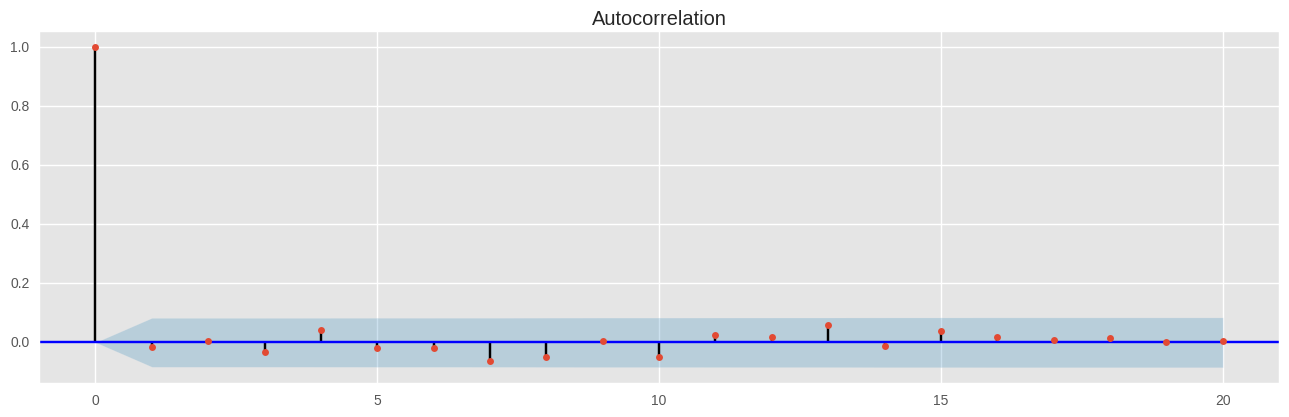

In [304]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(retornos["ITUB4"], lags=20, ax=ax1)

However, the sample ACF of the squared returns illustrates the degree of persistence in variance, and implies that GARCH modeling may significantly condition the data used in the subsequent tail estimation process.

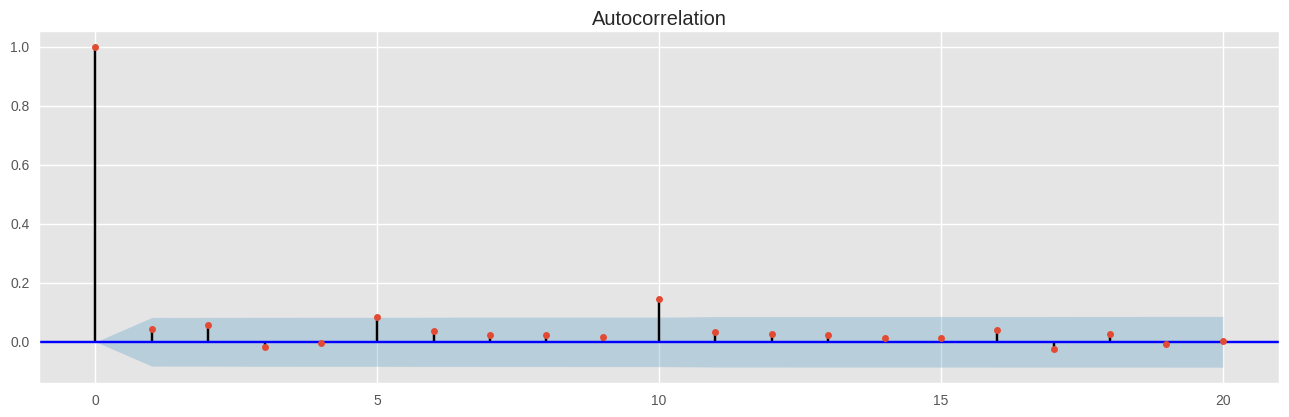

In [305]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ITUB4"]**2, lags=20, ax=ax1)

To produce a series of i.i.d. observations, fit a first order autoregressive model to the conditional mean of the returns of each equity index

$$r_t = c + \theta r_{t-1} + \epsilon_t$$

and an asymmetric GARCH model to the conditional variance

$$\sigma^2_t = \kappa + \alpha\sigma^2_{t-1} + \phi\epsilon^2_{t-1} + \psi[\epsilon_{t-1}<0]\epsilon^2_{t-1}$$

The first order autoregressive model compensates for autocorrelation, while the GARCH model compensates for heteroskedasticity. In particular, the last term incorporates asymmetry (leverage) into the variance by a Boolean indicator that takes the value 1 if the prior model residual is negative and 0 otherwise (see Glosten, Jagannathan, & Runkle [3]).

Additionally, the standardized residuals of each index are modeled as a standardized Student's t distribution to compensate for the fat tails often associated with equity returns. That is

$$z_t = \epsilon_t/\sigma_t$$ i.i.d. distributed $$t(\nu)$$

The following code segment extracts the filtered residuals and conditional variances from the returns of each equity index.

Pacote python utilizado http://arch.readthedocs.io/en/latest/univariate/introduction.html

In [306]:
arch_model_fit = []

for x in range(N):
    arch_model_fit.append(arch.arch_model(retornos.ix[:,x], mean='AR', vol='GARCH', dist = 'StudentsT').fit())

Iteration:      1,   Func. Count:      7,   Neg. LLF: -1336.8665020646622
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1336.8790340328687
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1336.87903404
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      7,   Neg. LLF: -1064.6614681002097
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1064.6735309022006
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1064.6908834291553


/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     42,   Neg. LLF: -1064.820552149477
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1065.0529289992528
Iteration:      6,   Func. Count:     58,   Neg. LLF: -1065.1014929174114
Iteration:      7,   Func. Count:     68,   Neg. LLF: -1065.339045519886
Iteration:      8,   Func. Count:     76,   Neg. LLF: -1065.3752451120542
Iteration:      9,   Func. Count:     83,   Neg. LLF: -1065.3812612568083
Iteration:     10,   Func. Count:     90,   Neg. LLF: -1065.3817381521385
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1065.3818626662883
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1065.3825121740233
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1065.3835194720725
Iteration:     14,   Func. Count:    118,   Neg. LLF: -1065.3835787958749
Iteration:     15,   Func. Count:    125,   Neg. LLF: -1065.383601558664
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1065.38360156
         

/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     24,   Neg. LLF: -1315.8058088505147
Iteration:      3,   Func. Count:     41,   Neg. LLF: 1449.005423276944
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1282.6482681677273
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1270.6865465392436
Iteration:      6,   Func. Count:     66,   Neg. LLF: 961.4339547421323
Iteration:      7,   Func. Count:     75,   Neg. LLF: -258.6755461801406
Iteration:      8,   Func. Count:     92,   Neg. LLF: 1622.0169730779764
Iteration:      9,   Func. Count:     99,   Neg. LLF: 1524.7214914210247
Iteration:     10,   Func. Count:    106,   Neg. LLF: 377.5044678463744
Iteration:     11,   Func. Count:    115,   Neg. LLF: -474.20924807302436
Iteration:     12,   Func. Count:    123,   Neg. LLF: -595.1498840952731
Iteration:     13,   Func. Count:    131,   Neg. LLF: -645.2949559420572
Iteration:     14,   Func. Count:    140,   Neg. LLF: -883.5751595149529
Iteration:     15,   Func. Count:    149,   Neg. LLF

/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [307]:
parametros = pd.DataFrame()
residuos = pd.DataFrame()
volatilidade_condicional = pd.DataFrame()

for x in range(N):
    parametros[ativos[x]] = arch_model_fit[x].params
    volatilidade_condicional[ativos[x]] = arch_model_fit[x].conditional_volatility
    residuos[ativos[x]] = arch_model_fit[x].resid

residuos_normalizados = residuos/volatilidade_condicional

For the selected index, compare the model residuals and the corresponding conditional standard deviations filtered from the raw returns. The lower graph clearly illustrates the variation in volatility (heteroskedasticity) present in the filtered residuals.

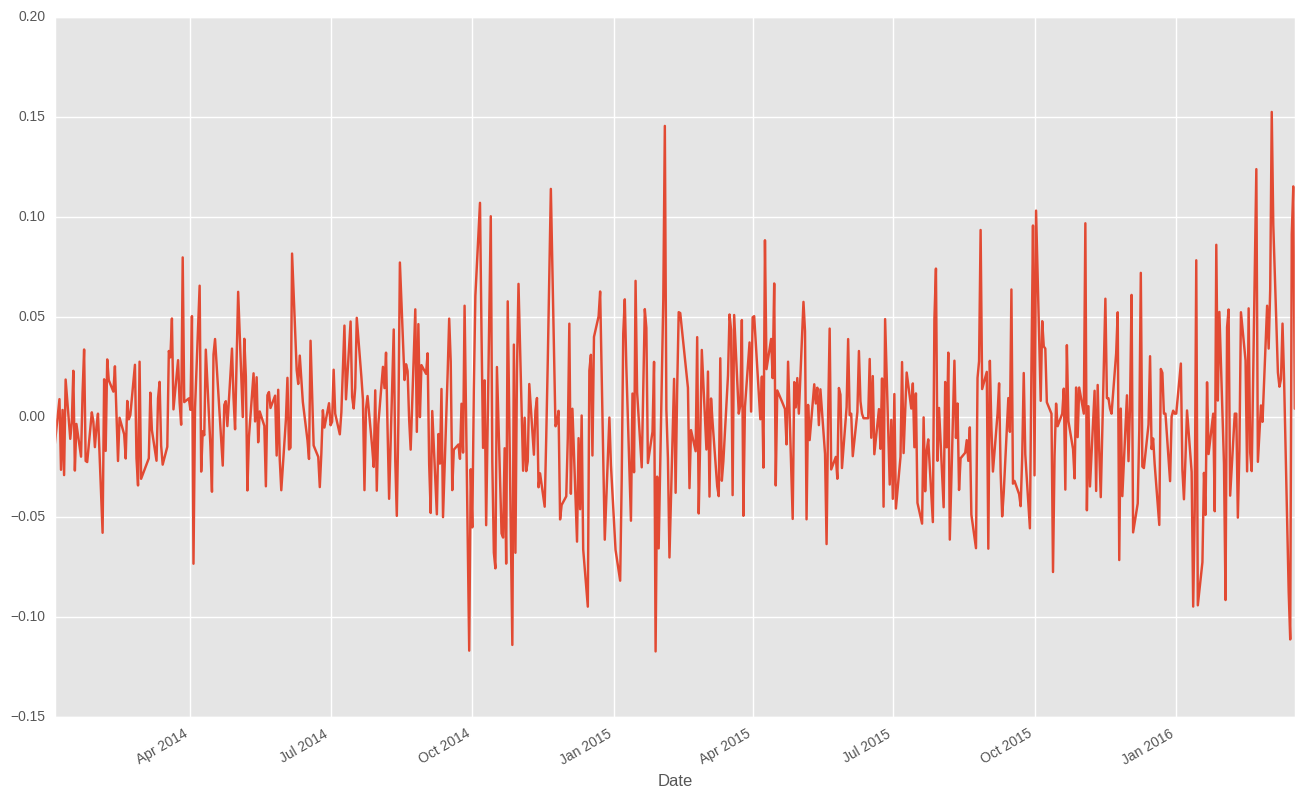

In [308]:
residuos.ix[:,1].plot(figsize=(16,10))

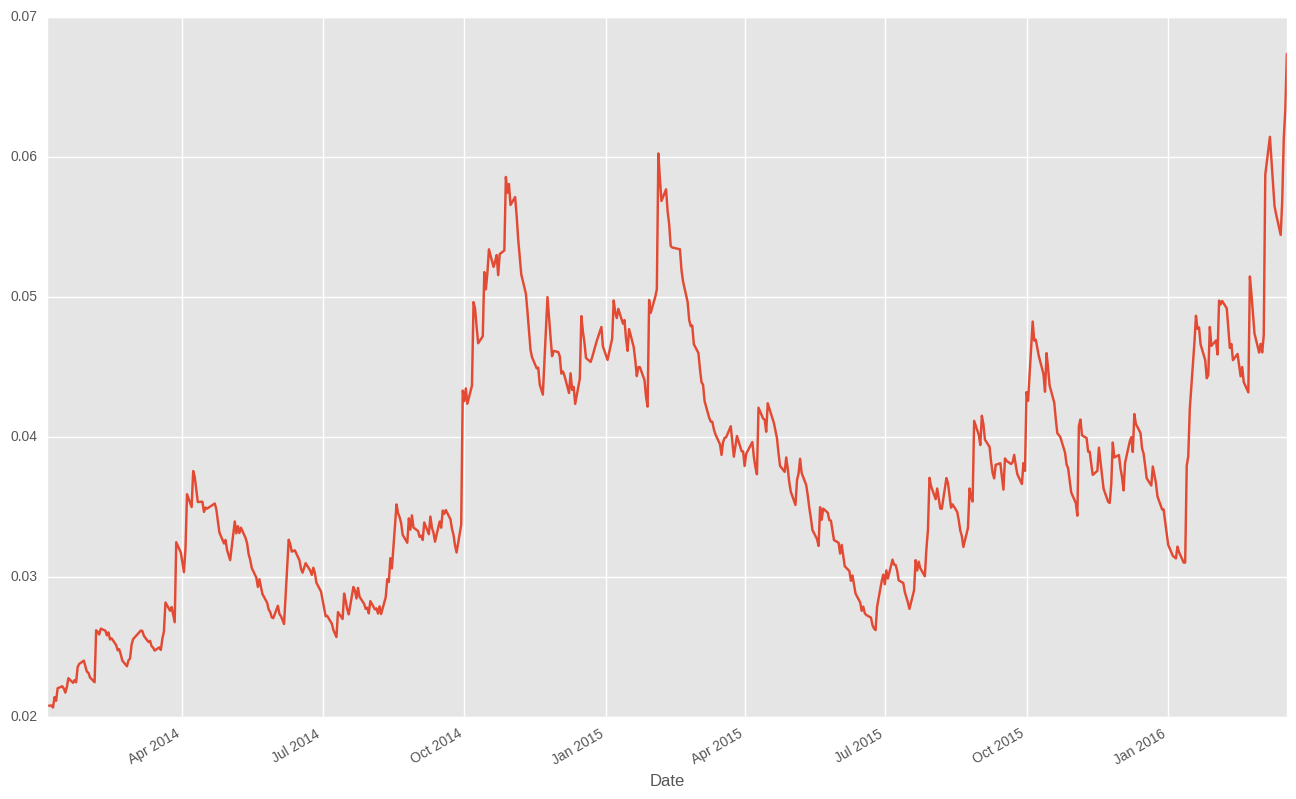

In [309]:
volatilidade_condicional.ix[:,1].plot(figsize=(16,10))

Having filtered the model residuals from each return series, standardize the residuals by the corresponding conditional standard deviation. These standardized residuals represent the underlying zero-mean, unit-variance, i.i.d. series upon which the EVT estimation of the sample CDF tails is based.

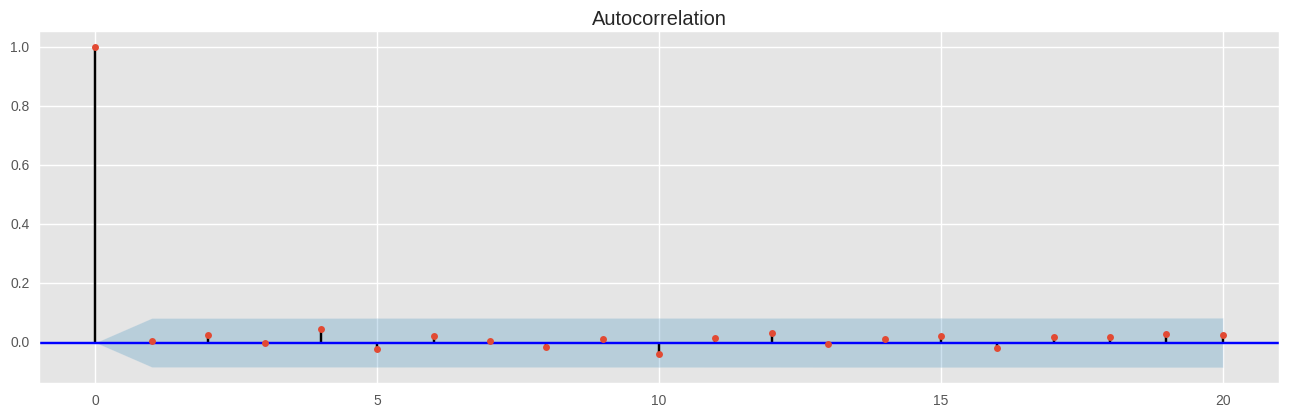

In [310]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuos_normalizados.ix[:,1], lags=20, ax=ax1)

Estimate the Semi-Parametric CDFs

In [311]:
uniforms = pd.DataFrame()
for x in range(N):
    uniforms[ativos[x]] = t.cdf(residuos_normalizados[ativos[x]],parametros[ativos[x]]['nu'])

In [312]:
uniforms.corr()

,FIBR3,PETR4,ITUB4,BBDC4
FIBR3,1.000000,-0.026735,-0.019243,-0.045873
PETR4,-0.026735,1.000000,0.632873,0.630363
ITUB4,-0.019243,0.632873,1.000000,0.863644
BBDC4,-0.045873,0.630363,0.863644,1.000000


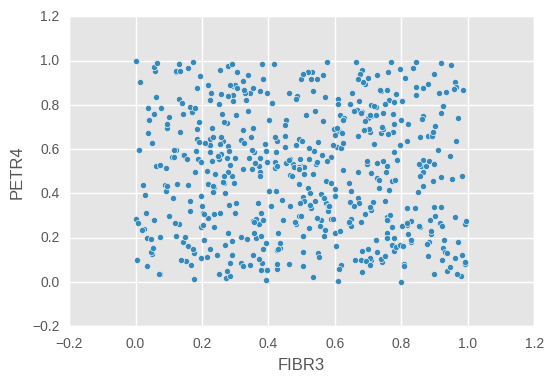

In [313]:
uniforms.ix[:,:2].plot(kind = 'scatter', x= 0, y = 1)

In [314]:
uniforms.to_csv('uniforms.csv')

### Simulandos os valores com a Copula simulada

### Calculando os valores ótimos

Nessa parte foi usado a função fitCopula do R

library(copula)

library(zoo)

uniform <- read.zoo("C:\\Users\\g4u55\\Downloads\\TCC-master\\TCC-master\\uniforms.csv",header = TRUE, sep = ",")

uniform = as.matrix(uniform)

set.seed(500)

tcop <- tCopula(dim = 4,dispstr = "un")

fit.t <- fitCopula(tcop, uniform, method="ml")

write.csv(coef(fit.t), file = "c://ParametrosOtimo.csv")

In [315]:
paramaros_otimos = pd.read_csv('ParametrosOtimo.csv')
paramaros_otimos = paramaros_otimos.drop('Unnamed: 0', 1)
paramaros_otimos

,x
0,0.450587
1,0.320444
2,0.474678
3,0.405968
4,0.712660
5,0.467890
6,6.261725


Utilizei a função rCopula do R

u <- rCopula(3965,tCopula(dim=4,dispstr = "un",coef(fit.t)[1:6],df=coef(fit.t)[7]))

write.csv(u, file = "c://CopulaOtimaSimulada.csv")

In [316]:
simulados = pd.read_csv('CopulaOtimaSimulada.csv')
simulados = simulados.drop('Unnamed: 0', 1)

In [317]:
simulados.corr()

,V1,V2,V3,V4
V1,1.000000,0.432235,0.266800,0.444507
V2,0.432235,1.000000,0.364509,0.681779
V3,0.266800,0.364509,1.000000,0.403415
V4,0.444507,0.681779,0.403415,1.000000


/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


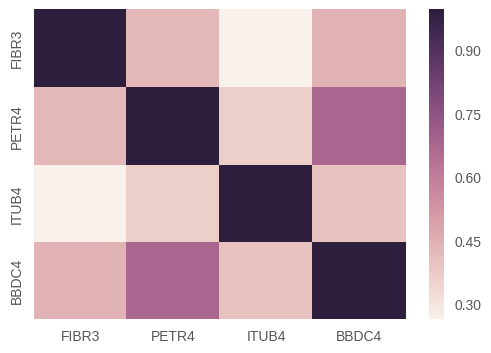

In [319]:
sns.heatmap(simulados.corr(), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [320]:
simulados.head()

,V1,V2,V3,V4
0,0.959884,0.990014,0.949032,0.924588
1,0.862362,0.502293,0.822147,0.776830
2,0.318489,0.271095,0.065277,0.056794
3,0.116601,0.276618,0.021025,0.039099
4,0.664528,0.617931,0.777534,0.821698


In [321]:
simulado_final = pd.DataFrame()

for x in range(N):
    simulado_final[ativos[x]] = t.ppf(simulados['V'+str(x+1)], parametros[ativos[x]]['nu'], loc=0, scale=1)

In [322]:
simulado_final = simulado_final*volatilidade_condicional[-1:].iloc[0]*100

In [323]:
simulado_final.head()

,FIBR3,PETR4,ITUB4,BBDC4
0,6.666521,18.148560,7.292027,16.423930
1,3.925302,0.039533,3.757687,8.663709
2,-1.649446,-4.228078,-6.607883,-18.115177
3,-4.319376,-4.111165,-9.785199,-20.204094
4,1.483053,2.068344,3.067418,10.496959


In [324]:
simulado_final_carteira = simulado_final.sum(axis=1)/4

In [325]:
simulado_final_carteira.head()

0    12.132760
1     4.096558
2    -7.650146
3    -9.604958
4     4.278943
dtype: float64

In [326]:
simulado_final_carteira.quantile(0.05)

-8.81133563177871